# 07 - JavaScript Functions

Notebook to iterate on the best functions for the chart.

In [3]:
// libraries
var fs = require('fs');
var http = require('http');

var d3 = require('d3');
var d3_sankey = require('d3-sankey');

var jsdom = require('jsdom');

// files
var f1 = '../data/indexed-courses.json'; // new line delimited

### Reusable Functions

In [4]:
function read_json(f) {
    var buffer = fs.readFileSync(f);
    var contents = JSON.parse(buffer);
    return contents;
}

// Function to create and return an svg for our virtual DOM
function svgDOM(width, height) {
  // Setup DOM
  var document = new jsdom.JSDOM();
  var body = d3.select(document.window.document.body);
    
  // Create svg node
  return body.append('svg')
    .attr('xmlns', 'http://www.w3.org/2000/svg')
    .attr('xmlns:xlink', 'http://www.w3.org/1999/xlink')
    .attr('width', width)
    .attr('height', height);
}


### Application Specific Functions

*Data Specific*

In [5]:
function create_course_graph(course, courses) {
    var final_nodes = new Set(),
        final_links = new Set(),
        remaining_nodes = [],
        next_nodes = [];
    
    var traverse = [{linkType : "prereqs",
                      nodeType : "source"}];
    
    // sanity check!!
    course = courses[course];
    final_nodes.add(course.courseID);

    // initially add all the prereqs from a class 
    // to BOTH the final and remaining nodes
    course['prereqs'].forEach((link) => {
        // set to check against
        final_nodes.add(link['source']);
        // links
        final_links.add(link);
        // list
        remaining_nodes.push(link['source']);
    });
    
    // map the courseIDs back to actual courses
    final_nodes = Array.from(final_nodes).map(d => { return courses[d]; });
    // Convert links too
    final_links = Array.from(final_links);
    
    return {"nodes": final_nodes, "links": final_links};
}

function create_course_graph_extended(course, courses) {
    var final_nodes = new Set(),
        final_links = new Set(),
        remaining_nodes = [],
        next_nodes = [];
    
    var traverse = [{linkType : "prereqs",
                      nodeType : "source"}];
    
    // sanity check!!
    course = courses[course];
    final_nodes.add(course.courseID);

    // initially add all the prereqs from a class 
    // to BOTH the final and remaining nodes
    course['prereqs'].forEach((link) => {
        // set to check against
        final_nodes.add(link['source']);
        // links
        final_links.add(link);
        // list
        remaining_nodes.push(link['source']);
    });

    // for each prereq, add it's prereqs
    remaining_nodes.forEach(function(node) {
        // get the course from it's ID
        node = courses[node];

        node['prereqs'].forEach(function(link) {

            var prereq_id = link['source'];
            if (final_nodes.has(prereq_id) == false) {
                next_nodes.push(link['source']);
                final_nodes.add(prereq_id);
                final_links.add(link);
            }
        });

    });
    
    // map the courseIDs back to actual courses
    final_nodes = Array.from(final_nodes).map(d => { return courses[d]; });
    // Convert links too
    final_links = Array.from(final_links);
    
    return {"nodes": final_nodes, "links": final_links};
}

function get_dept_courses(dept, courses) {
    var dept_courses = d3.values(courses)
        .filter(d => { return d.department === dept; })
        .map(d => { return d.courseID; });
    
    return dept_courses;
}

*Visualization*

In [15]:
function draw_chart(graph_orig) {
    var graph = graph_orig;
    
    // sanity check
    if (graph.links.length < 1 || graph.nodes.length < 1) {
        console.log("No links, skipping.");
        return;
    }
    
    var width = 960,
        height = 600,
        svg = svgDOM(width, height);

    var sankey = d3_sankey.sankey()
        .nodeId(function(d) { return d.courseID; })
        .nodeAlign(d3_sankey.sankeyCenter)
        .nodeWidth(15)
        .nodePadding(5)
        .size([width, height]);
    
    sankey(graph);

    var link = svg.append("g")
        .attr("class", "links")
        .attr("fill", "none")
        .attr("stroke", "#000")
        .attr("stroke-opacity", 0.2)
      .selectAll("path");
    var node = svg.append("g")
        .attr("class", "nodes")
        .attr("font-family", "sans-serif")
        .attr("font-size", 10)
      .selectAll("g");

    link = link
        .data(graph.links)
        .enter().append("path")
        .attr("d", d3_sankey.sankeyLinkHorizontal())
        .attr('class', 'link')
        .attr("stroke-width", function(d) { return Math.max(1, d.width); });

    node = node
        .data(graph.nodes)
        .enter().append("g")
        //.filter(function(d) { return (d['targetLinks'].length > 0) || (d['sourceLinks'].length > 0); })
        .attr('class', 'node');
    node.append("rect")
        .attr('class', 'node')
        .attr("x", function(d) { return d.x0; })
        .attr("y", function(d) { return d.y0; })
        .attr("height", function(d) { return d.y1 - d.y0; })
        .attr("width", function(d) { return d.x1 - d.x0; })
      .attr("fill", "steelblue")
        //.attr("fill", function(d) { return color_scale(d.department); })
        .attr("stroke", "#000");
    node.append("text")
        .attr("x", function(d) { return d.x0 - 6; })
        .attr("y", function(d) { return (d.y1 + d.y0) / 2; })
        .attr("dy", "0.35em")
        .attr('class', '')
        .attr("text-anchor", "end")
        .text(function(d) { return d.name; })
      .filter(function(d) { return d.x0 < width / 2; })
        .attr("x", function(d) { return d.x1 + 6; })
        .attr("text-anchor", "start");

    //return svg;
    return $$.svg(svg.node().outerHTML);
}

### Data and Test Vars

In [16]:
var courses = read_json(f1);

var algorithms = 'CS:3330';

var algo_graph = create_course_graph(algorithms, courses);

var algo_graph_extended = create_course_graph_extended(algorithms, courses);

---

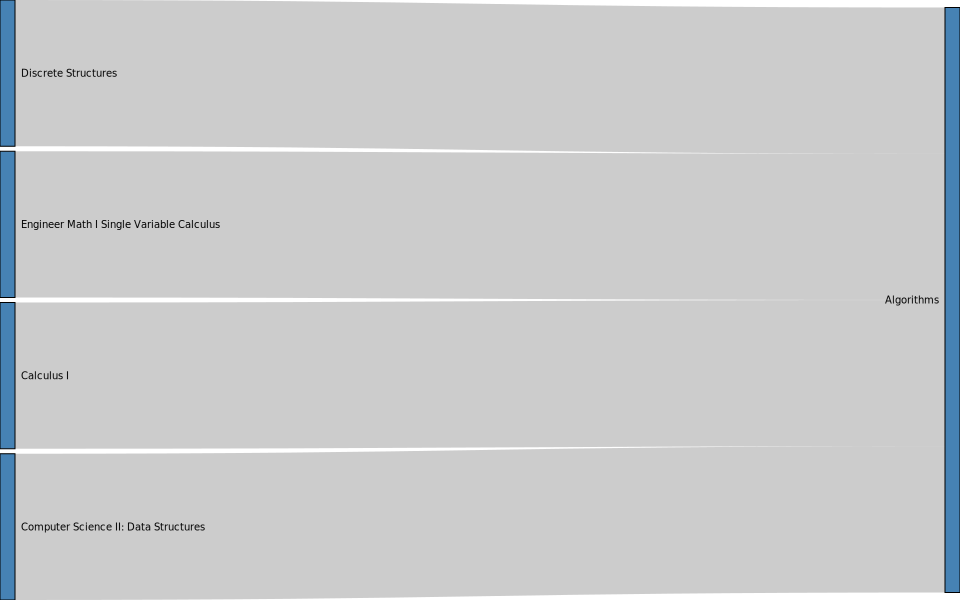

In [17]:
draw_chart(algo_graph)

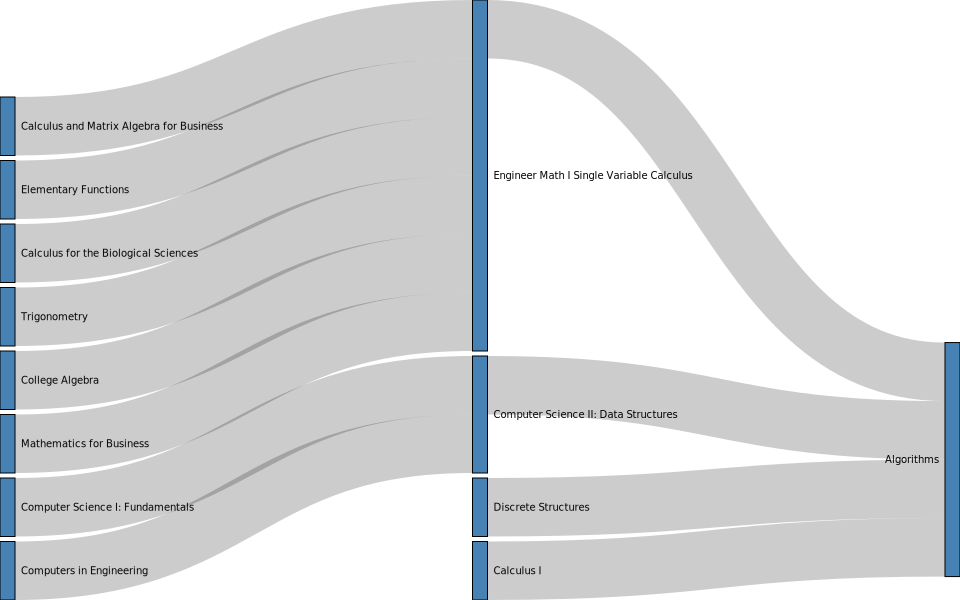

In [18]:
draw_chart(algo_graph_extended);

In [10]:
var cs_courses = get_dept_courses('CS', courses);

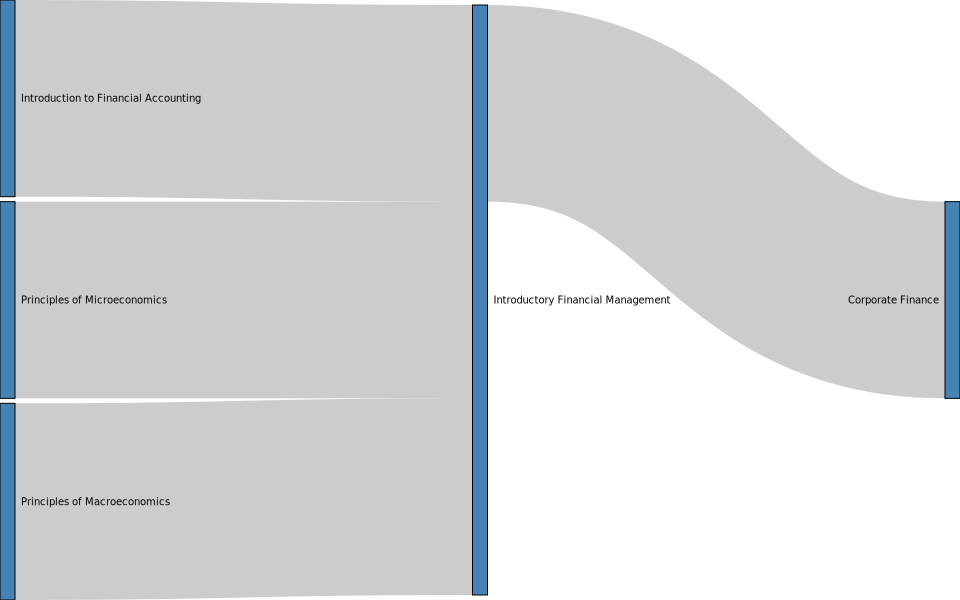

In [25]:
draw_chart(create_course_graph_extended('FIN:3300', courses))